# Chapter 5

ライブラリの読み込みと関数の定義

In [1]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.family'] ='sans-serif' #使用するフォント
plt.rcParams['xtick.direction'] = 'in' #x軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams['ytick.direction'] = 'in' #y軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams['xtick.major.width'] = 1.0 #x軸主目盛り線の線幅
plt.rcParams['ytick.major.width'] = 1.0 #y軸主目盛り線の線幅
plt.rcParams['font.size'] = 10 #フォントの大きさ
plt.rcParams['axes.linewidth'] = 1.0 # 軸の線幅edge linewidth。囲みの太さ
plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams['axes.xmargin'] = '0' #'.05'
plt.rcParams['axes.ymargin'] = '0.05'
plt.rcParams['savefig.facecolor'] = 'None'
plt.rcParams['savefig.edgecolor'] = 'None'


In [2]:
# 線種を変更するジェネレータ
def linestyle_generator():
    linestyle = ['-', '--', '-.', ':']
    lineID = 0
    while True:
        yield linestyle[lineID]
        lineID = (lineID + 1) % len(linestyle)

# 時間応答のグラフを整える関数
def plot_set(fig_ax, *args):
    fig_ax.set_xlabel(args[0])
    fig_ax.set_ylabel(args[1])
    fig_ax.grid(ls=':')
    if len(args)==3:
        fig_ax.legend(loc=args[2])

# ボード線図を整える関数
def bodeplot_set(fig_ax, *args):
    fig_ax[0].grid(which='both', ls=':')
    fig_ax[0].set_ylabel('Gain [dB]')

    fig_ax[1].grid(which='both', ls=':')
    fig_ax[1].set_xlabel('$\\omega$ [rad/s]')
    fig_ax[1].set_ylabel('Phase [deg]')

    if len(args) > 0:
        fig_ax[1].legend(loc=args[0])
    if len(args) > 1:
        fig_ax[0].legend(loc=args[1])


## 垂直駆動アームの角度追従制御

In [3]:
from control.matlab import tf, feedback, step, bode, logspace, mag2db


In [4]:
g  = 9.81                # 重力加速度[m/s^2]
l  = 0.2                 # アームの長さ[m]
M  = 0.5                 # アームの質量[kg]
mu = 1.5e-2              # 粘性摩擦係数[kg*m^2/s]
J  = 1.0e-2              # 慣性モーメント[kg*m^2]

P = tf( [0,1], [J, mu, M*g*l] )

ref = 30 # 目標角度 [deg]


ステップ応答のオーバーシュートや整定時間などを調べる

In [5]:
from control.matlab import stepinfo
info = stepinfo(P, SettlingTimeThreshold=0.05)
info


{'RiseTime': 0.12686419245146258,
 'SettlingTime': 3.8820442890147544,
 'SettlingMin': 0.3869097474111556,
 'SettlingMax': 1.8169776184368178,
 'Overshoot': 78.24550436865185,
 'Undershoot': 0,
 'Peak': 1.8169776184368178,
 'PeakTime': 0.32984690037380265,
 'SteadyStateValue': 1.019367991845056}

ピークゲインとバンド幅を調べる

In [6]:
from control.matlab import bode, logspace, mag2db
# from scipy.signal import argrelmax

# ピークゲイン
mag, _, w = bode(P, logspace(-1,2,1000), plot=False)
print(f'ピークゲイン Mp = {mag2db(mag.max())} [dB]')

# [maxId] = argrelmax(mag)
# print('wp=', w[maxId])
# print('ピークゲイン Mp=', mag2db(mag[maxId]))

# バンド幅
print(f'バンド幅 wbw = {P.bandwidth()} [rad/s]')


ピークゲイン Mp = 16.584713001907232 [dB]
バンド幅 wbw = 15.321579070586944 [rad/s]


### P制御

Pゲインと応答の関係

(0.0, 50.0)

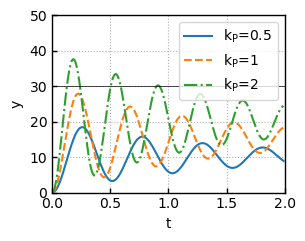

In [7]:
kp = (0.5, 1, 2) # 比例ゲイン

LS = linestyle_generator()
fig, ax = plt.subplots(figsize=(3, 2.3))
for i in range(len(kp)):
    K = tf([0, kp[i]], [0, 1])
    Gyr = feedback(P*K, 1)
    y,t = step(Gyr, np.arange(0, 2, 0.01))

    pltargs = {'ls': next(LS), 'label': f'$k_P$={kp[i]}'}
    ax.plot(t, y*ref, **pltargs)

ax.axhline(ref, color="k", linewidth=0.5)
plot_set(ax, 't', 'y', 'best')

ax.set_xlim(0, 2)
ax.set_ylim(0, 50)

# fig.savefig("pcont.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)


Pゲインと周波数特性の関係

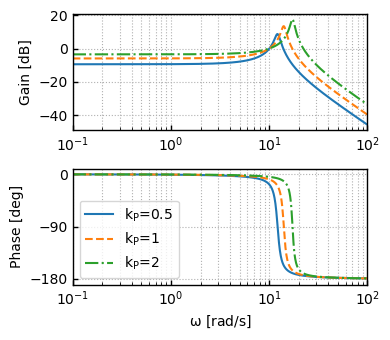

In [8]:
LS = linestyle_generator()
fig, ax = plt.subplots(2, 1, figsize=(4, 3.5))
for i in range(len(kp)):
    K = tf([0, kp[i]], [0, 1])
    Gyr = feedback(P*K, 1)
    mag, phase, w = bode(Gyr, logspace(-1,2,1000), plot=False)

    pltargs = {'ls': next(LS), 'label': f'$k_P$={kp[i]}'}
    ax[0].semilogx(w, mag2db(mag), **pltargs)
    ax[1].semilogx(w, np.rad2deg(phase), **pltargs)

bodeplot_set(ax, 'lower left')

ax[1].set_ylim(-190,10)
ax[1].set_yticks([-180,-90,0])

fig.tight_layout()
# fig.savefig("pcont_bode.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)


### PD制御

Dゲインと応答の関係

(0.0, 50.0)

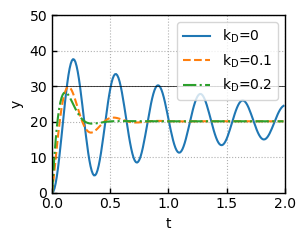

In [9]:
kp = 2 #比例ゲイン
kd = (0, 0.1, 0.2) # 微分ゲイン

LS = linestyle_generator()
fig, ax = plt.subplots(figsize=(3, 2.3))
for i in range(len(kd)):
    K = tf([kd[i], kp], [0, 1])
    Gyr = feedback(P*K, 1)
    y,t = step(Gyr, np.arange(0, 2, 0.01))

    pltargs = {'ls': next(LS), 'label': f'$k_D$={kd[i]}'}
    ax.plot(t, y*ref, **pltargs)

ax.axhline(ref, color="k", linewidth=0.5)
plot_set(ax, 't', 'y', 'best')

ax.set_xlim(0, 2)
ax.set_ylim(0, 50)

#fig.savefig("pdcont.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)


Dゲインと周波数特性の関係

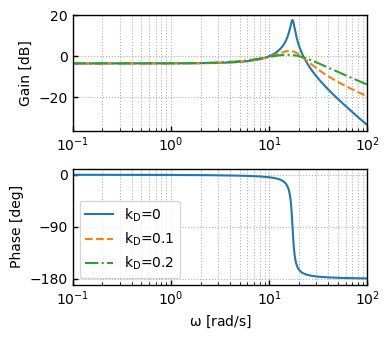

In [10]:
LS = linestyle_generator()
fig, ax = plt.subplots(2, 1, figsize=(4, 3.5))

for i in range(len(kd)):
    K = tf([kd[i], kp], [0,1])
    Gyr = feedback(P*K, 1)
    mag, phase, w = bode(Gyr, logspace(-1,2,1000), plot=False)

    pltargs = {'ls': next(LS), 'label': f'$k_D$={kd[i]}'}
    ax[0].semilogx(w, mag2db(mag), **pltargs)
    ax[1].semilogx(w, np.rad2deg(phase), **pltargs)

bodeplot_set(ax, 'lower left')

ax[1].set_ylim(-190,10)
ax[1].set_yticks([-180,-90,0])

fig.tight_layout()
# fig.savefig("pdcont_bode.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)


### PID制御

Iゲインと応答の関係

(0.0, 50.0)

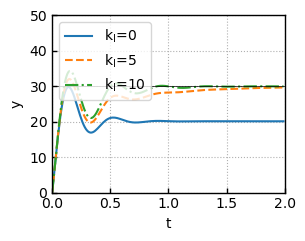

In [11]:
kp = 2 # 比例ゲイン
kd = 0.1 # 微分ゲイン
ki = (0, 5, 10) # 積分ゲイン

LS = linestyle_generator()
fig, ax = plt.subplots(figsize=(3, 2.3))

for i in range(len(ki)):
    K = tf([kd, kp, ki[i]], [1, 0])
    Gyr = feedback(P*K, 1)
    y, t = step(Gyr, np.arange(0, 2, 0.01))

    pltargs = {'ls': next(LS), 'label': f'$k_I$={ki[i]}'}
    ax.plot(t, y*ref, **pltargs)

ax.axhline(ref, color="k", linewidth=0.5)
plot_set(ax, 't', 'y', 'upper left')

ax.set_xlim(0, 2)
ax.set_ylim(0,50)

# fig.savefig("pidcont.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)


Iゲインと周波数特性の関係

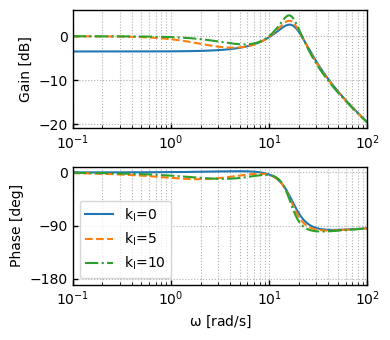

In [12]:
LS = linestyle_generator()
fig, ax = plt.subplots(2, 1, figsize=(4, 3.5))

for i in range(len(ki)):
    K = tf([kd, kp, ki[i]], [1, 0])
    Gyr = feedback(P*K,1)
    mag, phase, w = bode(Gyr, logspace(-1,2,1000), plot=False, wrap_phase = True)

    pltargs = {'ls': next(LS), 'label': f'$k_I$={ki[i]}'}
    ax[0].semilogx(w, mag2db(mag), **pltargs)
    ax[1].semilogx(w, np.rad2deg(phase), **pltargs)

bodeplot_set(ax, 'best')

ax[1].set_ylim(-190,10)
ax[1].set_yticks([-180,-90,0])

fig.tight_layout()
# fig.savefig("pidcont_bode.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)


### 練習問題（外乱抑制）

(-0.05, 0.5)

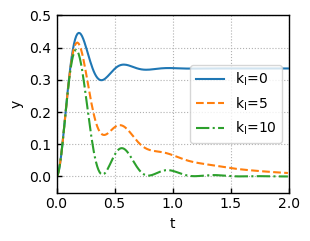

In [13]:
LS = linestyle_generator()
fig, ax = plt.subplots(figsize=(3, 2.3))

for i in range(len(ki)):
    K = tf([kd, kp, ki[i]], [1, 0])
    Gyd = feedback(P, K)
    y, t = step(Gyd, np.arange(0, 2, 0.01))

    pltargs = {'ls': next(LS), 'label': f'$k_I$={ki[i]}'}
    ax.plot(t, y, **pltargs)

plot_set(ax, 't', 'y', 'center right')
ax.set_xlim(0, 2)
ax.set_ylim(-0.05, 0.5)

# fig.savefig("pidcont_dis.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)


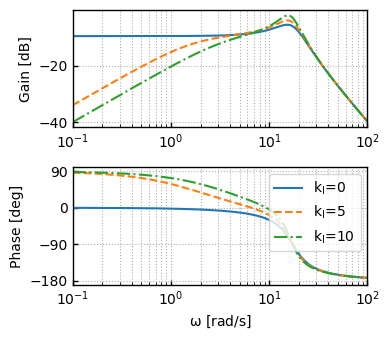

In [14]:
LS = linestyle_generator()
fig, ax = plt.subplots(2, 1, figsize=(4, 3.5))

for i in range(len(ki)):
    K = tf([kd, kp, ki[i]], [1,0])
    Gyd = feedback(P, K)
    mag, phase, w = bode(Gyd, logspace(-1,2,1000), plot=False, wrap_phase=True)

    pltargs = {'ls': next(LS), 'label': f'$k_I$={ki[i]}'}
    ax[0].semilogx(w, mag2db(mag), **pltargs)
    ax[1].semilogx(w, np.rad2deg(phase), **pltargs)

bodeplot_set(ax, 'best')

ax[1].set_ylim(-190,100)
ax[1].set_yticks([-180,-90, 0, 90])

fig.tight_layout()
# fig.savefig("pidcont_dis_bode.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)


## 2自由度制御

In [15]:
from control.matlab import tf, feedback, lsim

kp, ki, kd = 2, 10, 0.1
K1 = tf([kd, kp, ki], [1, 0])
K2 = tf([kp, ki], [kd, kp, ki]) # PI-D
K3 = tf([0, ki], [kd, kp, ki]) # I-PD


### PI-D制御

/Users/minami/opt/anaconda3/envs/bookpython/lib/python3.11/site-packages/control/timeresp.py:940: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(


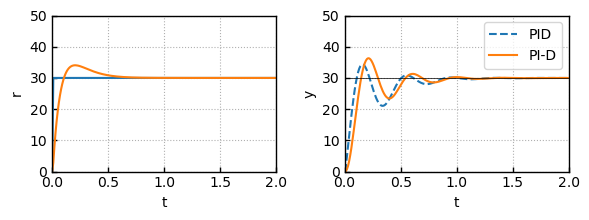

In [16]:
Gyz = feedback(P*K1, 1)

Td = np.arange(0, 2, 0.01)
r = 1*(Td>0)

z, t, _ = lsim(K2, r, Td, 0)

fig, ax = plt.subplots(1, 2, figsize=(6, 2.3))

y, _, _ = lsim(Gyz, r, Td, 0)
ax[0].plot(t, r*ref)
ax[1].plot(t, y*ref, ls='--', label='PID')

y, _, _ = lsim(Gyz, z, Td, 0)
ax[0].plot(t, z*ref)
ax[1].plot(t, y*ref, label='PI-D')

plot_set(ax[0], 't', 'r')
ax[0].set_xlim(0, 2)
ax[0].set_ylim(0,50)

ax[1].axhline(ref, color="k", linewidth=0.5)
plot_set(ax[1], 't', 'y', 'best')

ax[1].set_xlim(0, 2)
ax[1].set_ylim(0,50)

fig.tight_layout()
# fig.savefig("2deg1.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)


制御入力の計算

PID制御では，$G_{ur}$ がインプロパーになるので，擬似微分を用いて計算する

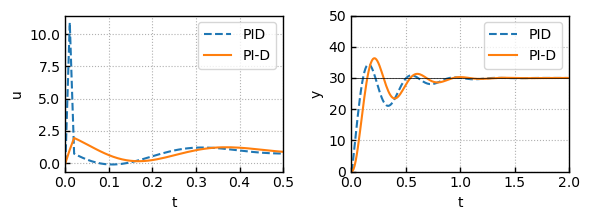

In [17]:
tau = 0.0000001 # ローパスフィルタ
Klp = tf([kd, 0], [tau, 1]) # 擬似微分器
Ktau = tf([kp, ki], [1, 0]) + Klp

Gyz = feedback(P*Ktau, 1)
Guz = Ktau/(1+P*Ktau)

Td = np.arange(0, 2, 0.01)
r = 1*(Td>0)

z, t, _ = lsim(K2, r, Td, 0)

fig, ax = plt.subplots(1, 2, figsize=(6, 2.3))

u, _, _ = lsim(Guz, r, Td, 0)
ax[0].plot(t, u, ls='--', label='PID')

u, _, _ = lsim(Guz, z, Td, 0)
ax[0].plot(t, u, label='PI-D')

y, _, _ = lsim(Gyz, r, Td, 0)
ax[1].plot(t, y*ref, ls='--', label='PID')

y, _, _ = lsim(Gyz, z, Td, 0)
ax[1].plot(t, y*ref, label='PI-D')

ax[0].set_xlim(0, 0.5)
ax[1].axhline(ref, color="k", linewidth=0.5)
plot_set(ax[0], 't', 'u', 'best')
plot_set(ax[1], 't', 'y', 'best')
ax[1].set_xlim(0, 2)
ax[1].set_ylim(0,50)

fig.tight_layout()
# fig.savefig("2deg1_u.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)


### I-PD制御

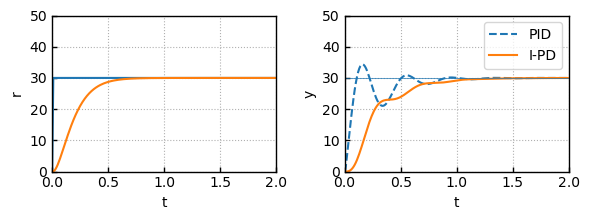

In [18]:
Gyz = feedback(P*K1, 1)

Td = np.arange(0, 2, 0.01)
r = 1*(Td>0)

z, t, _ = lsim(K3, r, Td, 0)

fig, ax = plt.subplots(1, 2, figsize=(6, 2.3))

y, _, _ = lsim(Gyz, r, Td, 0)
ax[0].plot(t, r*ref)
ax[1].plot(t, y*ref, ls='--', label='PID')

y, _, _ = lsim(Gyz, z, Td, 0)
ax[0].plot(t, z*ref)
ax[1].plot(t, y*ref, label='I-PD')

plot_set(ax[0], 't', 'r')
ax[0].set_xlim(0, 2)
ax[0].set_ylim(0,50)

ax[1].axhline(ref, linewidth=0.5)
plot_set(ax[1], 't', 'y', 'best')

ax[1].set_xlim(0, 2)
ax[1].set_ylim(0,50)

fig.tight_layout()
# fig.savefig("2deg2.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)


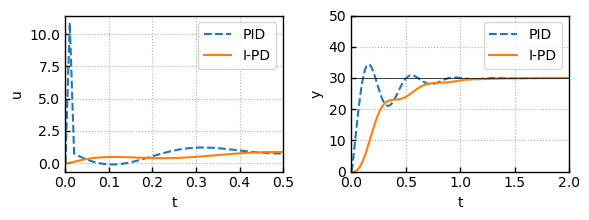

In [19]:
tau = 0.0000001 # ローパスフィルタ
Klp = tf([kd, 0], [tau, 1]) # 擬似微分器
Ktau = tf([kp, ki], [1, 0]) + Klp

Gyz = feedback(P*Ktau, 1)
Guz = Ktau/(1+P*Ktau)

Td = np.arange(0, 2, 0.01)
r = 1*(Td>0)

z, t, _ = lsim(K3, r, Td, 0)

fig, ax = plt.subplots(1, 2, figsize=(6, 2.3))

u, _, _ = lsim(Guz, r, Td, 0)
ax[0].plot(t, u, ls='--', label='PID')

u, _, _ = lsim(Guz, z, Td, 0)
ax[0].plot(t, u, label='I-PD')

y, _, _ = lsim(Gyz, r, Td, 0)
ax[1].plot(t, y*ref, ls='--', label='PID')

y, _, _ = lsim(Gyz, z, Td, 0)
ax[1].plot(t, y*ref, label='I-PD')

ax[0].set_xlim(0, 0.5)

ax[1].axhline(ref, color="k", linewidth=0.5)
plot_set(ax[0], 't', 'u', 'best')
plot_set(ax[1], 't', 'y', 'best')
ax[1].set_xlim(0, 2)
ax[1].set_ylim(0,50)


fig.tight_layout()
# fig.savefig("2deg2_u.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)


# 限界感度法

### 無駄時間要素

In [20]:
from control.matlab import tf, pade, rlocus, poles, feedback, step


In [21]:
g  = 9.81                # 重力加速度[m/s^2]
l  = 0.2                 # アームの長さ[m]
M  = 0.5                 # アームの質量[kg]
mu = 1.5e-2              # 粘性摩擦係数[kg*m^2/s]
J  = 1.0e-2              # 慣性モーメント[kg*m^2]

P = tf( [0,1], [J, mu, M*g*l] )

ref = 30 # 目標角度 [deg]


In [22]:
# num_delay, den_delay = pade( 0.005, 5)
num_delay, den_delay = pade( 0.005, 1) # 1次のパデ近似
Pdelay = P * tf(num_delay, den_delay)
Pdelay
print(poles(Pdelay))


[-400.  +0.j           -0.75+9.87610753j   -0.75-9.87610753j]


根軌跡を描くと，Pゲインを大きくすることで不安定になることがわかる

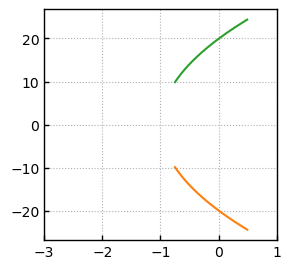

In [23]:
kvect = np.arange(0, 5, 0.001)
rlist, klist = rlocus(Pdelay, kvect, plot=False)
fig, ax = plt.subplots(figsize=(3,3))

ax.plot(rlist.real, rlist.imag)
ax.set_xlim(-3, 1)
ax.grid(ls=':')


無駄時間要素がない場合は，制御対象は２次遅れ系なので，Pゲインを大きくしても不安定にならない

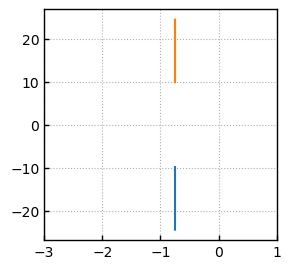

In [24]:
rlist, klist = rlocus(P, kvect, plot=False)
fig, ax = plt.subplots(figsize=(3,3))

ax.plot(rlist.real, rlist.imag)
ax.set_xlim(-3, 1)
ax.grid(ls=':')


### チューニング

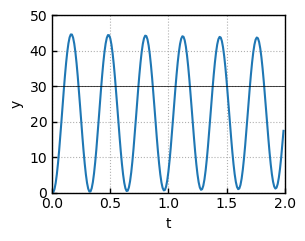

In [25]:
kp0 = 2.9 # 比例ゲイン
K = tf([0, kp0], [0, 1]) # P制御
Gyr = feedback(Pdelay*K, 1) # 閉ループ系
y,t = step(Gyr, np.arange(0, 2, 0.01)) # ステップ応答

fig, ax = plt.subplots(figsize=(3, 2.3))
ax.plot(t, y*ref)

ax.axhline(ref, color='k', linewidth=0.5)
ax.set_xlim(0, 2)
ax.set_ylim(0, 50)
plot_set(ax, 't', 'y')

# fig.savefig("tune_zn.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)


Classic
kP= 1.74
kI= 11.6
kD= 0.06525
------------------
No Overshoot
kP= 0.58
kI= 3.8666666666666667
kD= 0.05742
------------------


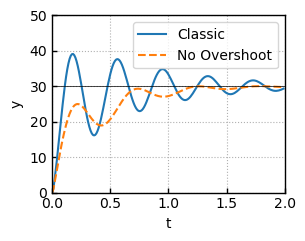

In [26]:
kp = [0, 0]
ki = [0, 0]
kd = [0, 0]
Rule = ['', '']

T0 = 0.3 # 周期
# Classic ZN
Rule[0] = 'Classic'
kp[0] = 0.6 * kp0
ki[0] = kp[0] / (0.5 * T0)
kd[0] = kp[0] * (0.125 * T0)

# No overshoot
Rule[1] = 'No Overshoot'
kp[1] = 0.2 * kp0
ki[1] = kp[1] / (0.5 * T0)
kd[1] = kp[1] * (0.33 * T0)

LS = linestyle_generator()
fig, ax = plt.subplots(figsize=(3, 2.3))

for i in range(2):
    K = tf([kd[i], kp[i], ki[i]], [1, 0])
    Gyr = feedback(Pdelay*K, 1)
    y, t = step(Gyr, np.arange(0, 2, 0.01))

    ax.plot(t, y*ref, ls=next(LS), label=Rule[i])

    print(Rule[i])
    print('kP=', kp[i])
    print('kI=', ki[i])
    print('kD=', kd[i])
    print('------------------')

ax.axhline(ref, color="k", linewidth=0.5)
ax.set_xlim(0, 2)
ax.set_ylim(0, 50)
plot_set(ax, 't', 'y', 'best')

# fig.savefig("tune_zn_result.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)


# モデルマッチング

閉ループ系Gyrの逆数のマクローリン展開

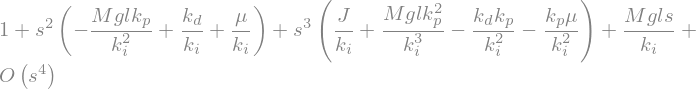

In [27]:
import sympy as sp
s = sp.Symbol('s')
kp, kd, ki = sp.symbols('k_p k_d k_i')
Mgl, mu, J = sp.symbols('Mgl mu J')
sp.init_printing()

G = (kp*s+ki)/(J*s**3 +(mu+kd)*s**2 + (Mgl + kp)*s + ki)
sp.series(1/G, s, 0, 4)


規範モデルMの逆数のマクローリン展開と比較し，PIDゲインを決定する

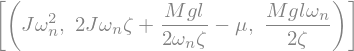

In [28]:
import sympy as sp
z, wn = sp.symbols('zeta omega_n')
kp, kd, ki = sp.symbols('k_p k_d k_i')
Mgl,mu,J = sp.symbols('Mgl mu J')
sp.init_printing()

f1 = Mgl/ki-2*z/wn
f2 = (mu+kd)/ki-Mgl*kp/(ki**2)-1/(wn**2)
f3 = J/ki-kp*(mu+kd)/(ki**2)+Mgl*kp**2/(ki**3)
sp.solve([f1, f2, f3],[kp, kd, ki])


In [29]:
from control.matlab import tf, step

g  = 9.81                # 重力加速度[m/s^2]
l  = 0.2                 # アームの長さ[m]
M  = 0.5                 # アームの質量[kg]
mu = 1.5e-2              # 粘性摩擦係数
J  = 1.0e-2              # 慣性モーメント

P = tf( [0,1], [J, mu, M*g*l] )

ref = 30 # 目標角度 [deg]


２次の規範モデル

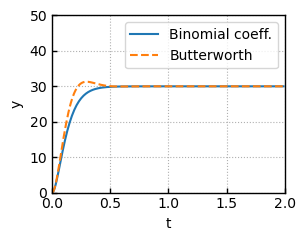

In [30]:
omega_n = 15
zeta = (1, 1/np.sqrt(2))
Label = ('Binomial coeff.', 'Butterworth')

LS = linestyle_generator()
fig, ax = plt.subplots(figsize=(3, 2.3))

for i in range(2):
    Msys = tf([0,omega_n**2], [1,2*zeta[i]*omega_n,omega_n**2])
    y, t = step(Msys, np.arange(0, 2, 0.01))

    ax.plot(t, y*ref, ls=next(LS), label=Label[i])

ax.set_xlim(0, 2)
ax.set_ylim(0, 50)
plot_set(ax, 't', 'y', 'best')

# fig.savefig("ref_model_2nd.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)


モデルマッチングで求めたPIDゲインを用いたときのステップ応答

この例の場合は，規範モデルの応答に完全に一致させることができる

kP= 2.25
kI= 10.406647807637908
kD= 0.2433517680339462


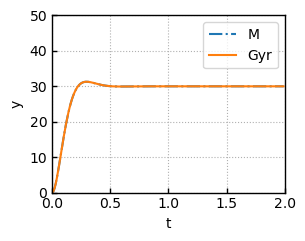

In [31]:
omega_n = 15
zeta = 0.707

Msys = tf([0,omega_n**2], [1,2*zeta*omega_n,omega_n**2])

kp = omega_n**2*J
ki = omega_n*M*g*l/(2*zeta)
kd = 2*zeta*omega_n*J + M*g*l/(2*zeta*omega_n) - mu

print('kP=', kp)
print('kI=', ki)
print('kD=', kd)

Gyr = tf([kp,ki], [J, mu+kd, M*g*l+kp, ki])

yM, tM = step(Msys, np.arange(0, 2, 0.01))
y, t = step(Gyr, np.arange(0, 2, 0.01))

fig, ax = plt.subplots(figsize=(3, 2.3))

ax.plot(tM, yM*ref, label='M', ls = '-.')
ax.plot(t, y*ref, label='Gyr')

ax.set_xlim(0, 2)
ax.set_ylim(0, 50)
plot_set(ax, 't', 'y', 'best')

# fig.savefig("model_match.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)


３次の規範モデル

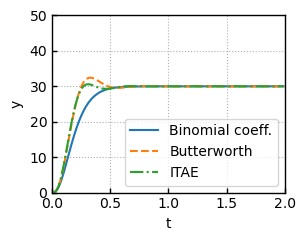

In [32]:
alpha1 = (3, 2, 2.15)
alpha2 = (3, 2, 1.75)
omega_n = 15
Label = ('Binomial coeff.', 'Butterworth', 'ITAE')

LS = linestyle_generator()
fig, ax = plt.subplots(figsize=(3, 2.3))

for i in range(3):
    Msys = tf([0, omega_n**3], [1, alpha2[i]*omega_n, alpha1[i]*omega_n**2, omega_n**3])
    y,t = step(Msys, np.arange(0, 2, 0.01))

    ax.plot(t, y*ref, ls=next(LS), label=Label[i])

ax.set_xlim(0, 2)
ax.set_ylim(0, 50)
plot_set(ax, 't', 'y', 'best')

# fig.savefig("ref_model_3rd.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)


### 練習問題

kP= 3.519
kI= 33.75
kD= 0.285


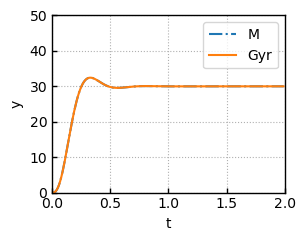

In [33]:
alpha1 = 2
alpha2 = 2
omega_n = 15

Msys = tf([0, omega_n**3], [1, alpha2*omega_n, alpha1*omega_n**2, omega_n**3])

kp = J*alpha1*omega_n**2 - M*g*l
ki = J*omega_n**3
kd = J*alpha2*omega_n - mu

print('kP=', kp)
print('kI=', ki)
print('kD=', kd)

Gyr = tf([0, ki], [J, mu+kd, M*g*l+kp, ki])

yM, tM = step(Msys, np.arange(0, 2, 0.01))
y, t = step(Gyr, np.arange(0, 2, 0.01))

fig, ax = plt.subplots(figsize=(3, 2.3))

ax.plot(tM, yM*ref, label='M', ls = '-.')
ax.plot(t, y*ref, label='Gyr')

ax.set_xlim(0, 2)
ax.set_ylim(0, 50)
plot_set(ax, 't', 'y', 'best')


## 状態フィードバック

### 極配置

In [34]:
from control.matlab import ss, acker, initial, lqr, care

# A = '0 1; -4 5'
# B = '0; 1'
# C = '1 0 ; 0 1'
# D = '0; 0'

A = [[0, 1], [-4, 5]]
B = [[0], [1]]
C = [[1, 0], [0, 1]]
D = [[0], [0]]
P = ss(A, B, C, D)
print(P)

<LinearIOSystem>: sys[241]
Inputs (1): ['u[0]']
Outputs (2): ['y[0]', 'y[1]']
States (2): ['x[0]', 'x[1]']

A = [[ 0.  1.]
     [-4.  5.]]

B = [[0.]
     [1.]]

C = [[1. 0.]
     [0. 1.]]

D = [[0.]
     [0.]]



A行列の固有値は不安定

In [35]:
np.linalg.eigvals(P.A)


array([1., 4.])

極配置で設計する。A+BFの固有値が指摘極polesになるように，ackerの結果に負号をつけています

In [36]:
regulator_poles = [-1, -1]
F = -acker(P.A, P.B, regulator_poles)
F


matrix([[ 3., -7.]])

A+BFの固有値が指摘した極になっています

In [37]:
np.linalg.eigvals(P.A+P.B@F)


array([-1., -1.])

matrix形式の場合は，P.A+P.B*F で計算できますが，ndarray形式の場合は，P.A+P.B@F とします。

ちなみに，1入力1出力の場合は，ndarray形式であっても，P.A+P.B*F の結果は，P.A+P.B@F と同じになります。

初期値応答を可視化

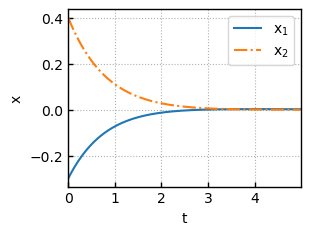

In [38]:
Acl = P.A + P.B@F
# Acl = P.A + P.B*F # 型がMatrixの場合
Pfb = ss(Acl, P.B, P.C, P.D)

Td = np.arange(0, 5, 0.01)
X0 = [-0.3, 0.4]
x, t = initial(Pfb, Td, X0) #ゼロ入力応答

fig, ax = plt.subplots(figsize=(3, 2.3))
ax.plot(t, x[:,0], label = '$x_1$')
ax.plot(t, x[:,1], ls = '-.', label = '$x_2$')

plot_set(ax, 't', 'x', 'best')

# fig.savefig("sf_pole.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)


### 最適レギュレータ

In [39]:
Q = np.diag( [100, 1] )
R = 1

F, X, E = lqr(P.A, P.B, Q, R)
F = -F

print('--- フィードバックゲイン ---')
print(F)
print(-(1/R)*P.B.T@X)
print('--- 閉ループ極 ---')
print(E)
print(np.linalg.eigvals(P.A+P.B@F))


--- フィードバックゲイン ---
[[ -6.77032961 -11.28813639]]
[[ -6.77032961 -11.28813639]]
--- 閉ループ極 ---
[-3.1440682+0.94083196j -3.1440682-0.94083196j]
[-3.14406819+0.94083198j -3.14406819-0.94083198j]


リッカチ方程式の解Xを用いてフィードバックゲインを求めてもよいです

In [40]:
FF = - (1/R)*(P.B.T)@X
FF


matrix([[ -6.77032961, -11.28813639]])

care関数でリッカチ方程式を解く

In [41]:
X, E, F = care(P.A, P.B, Q, R)
F = -F
print('--- フィードバックゲイン ---')
print(F)
print('--- 閉ループ極 ---')
print(E)


--- フィードバックゲイン ---
[[ -6.77032961 -11.28813639]]
--- 閉ループ極 ---
[-3.1440682+0.94083196j -3.1440682-0.94083196j]


最適レギュレータを用いたときの応答

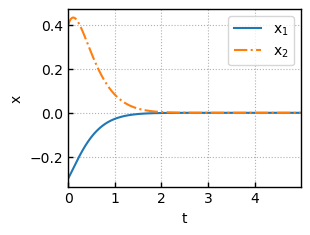

In [42]:
Acl = P.A + P.B@F
Pfb = ss(Acl, P.B, P.C, P.D)

tdata = np.arange(0, 5, 0.01)
xini, tini = initial(Pfb, tdata, [-0.3, 0.4]) #ゼロ入力応答

fig, ax = plt.subplots(figsize=(3, 2.3))

ax.plot(tini, xini[:,0], label = '$x_1$')
ax.plot(tini, xini[:,1], ls = '-.', label = '$x_2$')

ax.set_xlabel('t')
ax.set_ylabel('x')
ax.grid(ls=':')
ax.legend()

# fig.savefig("sf_lqr.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)


### 円条件（最適レギュレータのロバスト性）

In [43]:
from control.matlab import ss, nyquist, logspace

# A = '0 1; -4 5'
# B = '0; 1'
# C = '1 0 ; 0 1'
# D = '0; 0'

A = [[0, 1], [-4, 5]]
B = [[0], [1]]
C = [[1, 0], [0, 1]]
D = [[0], [0]]
P = ss(A, B, C, D)
L = ss(P.A, P.B, -F, 0)

print(L)

<LinearIOSystem>: sys[245]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']
States (2): ['x[0]', 'x[1]']

A = [[ 0.  1.]
     [-4.  5.]]

B = [[0.]
     [1.]]

C = [[ 6.77032961 11.28813639]]

D = [[0.]]



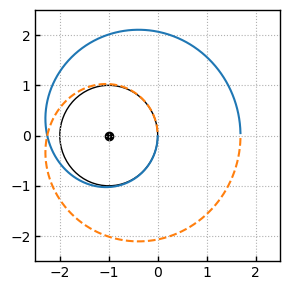

In [44]:
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(3, 3))
x, y, w = nyquist(L, logspace(-2,3,1000), plot=False)
ax.plot(x, y)
ax.plot(x, -y, ls='--')
ax.scatter(-1, 0, color='k')

ax.grid(ls=':')
ax.set_xlim(-2.5, 2.5)
ax.set_ylim(-2.5, 2.5)

c = patches.Circle(xy=(-1, 0), radius=1, fill=False, ec='k')
ax.add_patch(c)

fig.tight_layout()


開ループ系のナイキスト軌跡が (-1, 0j) を中心とする単位円の中に入りません

これにより，位相余裕が 60 [deg] 以上であることが保証されます

### ハミルトン行列

最適レギュレータを用いたときの閉ループ極は，ハミルトン行列の安定固有値に等しいです

In [45]:
# H1 = np.c_[P.A, -P.B*(1/R)*P.B.T]
# H2 = np.c_[ Q, P.A.T]
# H = np.r_[H1, -H2]

H = np.block( [ [P.A, -P.B*(1/R)@P.B.T], [-Q, -P.A.T]])
eigH = np.linalg.eigvals(H)
print(eigH)

print('--- ハミルトン行列の安定固有値 ---')
eigH_stable = [ i for i in eigH if i < 0]
print(eigH_stable)

F = -acker(P.A, P.B, eigH_stable)
print('--- フィードバックゲイン ---')
print(F)


[-3.14406819+0.94083198j -3.14406819-0.94083198j  3.14406819+0.94083198j
  3.14406819-0.94083198j]
--- ハミルトン行列の安定固有値 ---
[(-3.1440681937792814+0.9408319760374388j), (-3.1440681937792814-0.9408319760374388j)]
--- フィードバックゲイン ---
[[ -6.77032961 -11.28813639]]


## 積分サーボ系

In [46]:
from control.matlab import ss, acker, lsim


In [47]:
# A = '0 1; -4 5'
# B = '0; 1'
# C = '1 0 ; 0 1'
# D = '0; 0'

A = [[0, 1], [-4, 5]]
B = [[0], [1]]
C = [[1, 0], [0, 1]]
D = [[0], [0]]
P = ss(A, B, C, D)
print(P)

<LinearIOSystem>: sys[252]
Inputs (1): ['u[0]']
Outputs (2): ['y[0]', 'y[1]']
States (2): ['x[0]', 'x[1]']

A = [[ 0.  1.]
     [-4.  5.]]

B = [[0.]
     [1.]]

C = [[1. 0.]
     [0. 1.]]

D = [[0.]
     [0.]]



In [48]:
Pole = [-1, -1]
F = -acker(P.A, P.B, Pole)
F


matrix([[ 3., -7.]])

一定値の外乱がはいると，状態が０に収束しなくなります

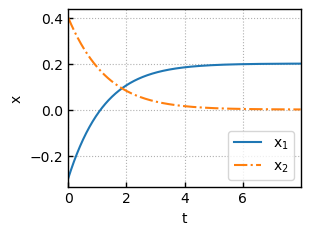

In [49]:
Acl = P.A + P.B@F
Pfb = ss(Acl, P.B, P.C, P.D)

Td = np.arange(0, 8, 0.01)
Ud = 0.2 * (Td>=0)
x, t, _ = lsim(Pfb, Ud, Td, [-0.3, 0.4])

fig, ax = plt.subplots(figsize=(3, 2.3))

ax.plot(t, x[:,0], label = '$x_1$')
ax.plot(t, x[:,1], ls = '-.', label = '$x_2$')
plot_set(ax, 't', 'x', 'best')

# fig.savefig("sf_dis.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)


拡大偏差系を構成し，積分型サーボ系を設計します

In [50]:
# A = '0 1; -4 5'
# B = '0; 1'
# C = '1 0'
# D = '0'

A = [[0, 1], [-4, 5]]
B = [[0], [1]]
C = [1, 0]
D = [0]
P = ss(A, B, C, D)
print(P)

# 拡大系
Abar = np.block([ [P.A, np.zeros((2,1))], [-P.C, 0] ])
Bbar = np.block([ [P.B], [0] ])
Cbar = np.block([ P.C, 0 ])

# Abar = np.r_[ np.c_[P.A, np.zeros((2,1))], -np.c_[ P.C, 0 ] ]
# Bbar = np.c_[ P.B.T, 0 ].T
# Cbar = np.c_[ P.C, 0 ]

<LinearIOSystem>: sys[254]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']
States (2): ['x[0]', 'x[1]']

A = [[ 0.  1.]
     [-4.  5.]]

B = [[0.]
     [1.]]

C = [[1. 0.]]

D = [[0.]]



In [51]:
Pole = [-1, -1, -5]
F = -acker(Abar, Bbar, Pole)
F


matrix([[ -7., -12.,   5.]])

積分型サーボ系を用いると，一定値の外乱がはいっても，状態が０に収束します

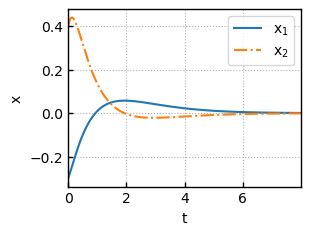

In [52]:
# Acl = P.A + P.B*F[0,0:2]
Acl = Abar + Bbar@F
Pfb = ss(Acl, Bbar, np.eye(3), np.zeros((3,1)))

Td = np.arange(0, 8, 0.01)
Ud = 0.2 * (Td>=0)
x, t, _ = lsim(Pfb, Ud, Td, [-0.3, 0.4, 0])

fig, ax = plt.subplots(figsize=(3, 2.3))
ax.plot(t, x[:,0], label = '$x_1$')
ax.plot(t, x[:,1], ls = '-.',label = '$x_2$')
# ax.plot(t, Ud, c='k')
plot_set(ax, 't', 'x', 'best')

# fig.savefig("servo.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)


## 可制御性，可観測性

In [53]:
from control.matlab import ss, ctrb, obsv


In [54]:
# A = '0 1; -4 5'
# B = '0; 1'
# C = '1 0'

A = [[0, 1], [-4, 5]]
B = [[0], [1]]
C = [1, 0]
P = ss(A, B, C, 0)
print(P)

<LinearIOSystem>: sys[256]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']
States (2): ['x[0]', 'x[1]']

A = [[ 0.  1.]
     [-4.  5.]]

B = [[0.]
     [1.]]

C = [[1. 0.]]

D = [[0.]]



可制御性行列をもとめ，それが正則であれば，システムは可制御となります

In [55]:
Uc = ctrb(P.A, P.B)
print('Uc=\n',Uc)
print('det(Uc)=', np.linalg.det(Uc))
print('rank(Uc)=', np.linalg.matrix_rank(Uc))


Uc=
 [[0. 1.]
 [1. 5.]]
det(Uc)= -1.0
rank(Uc)= 2


可観測性行列をもとめ，それが正則であれば，システムは可観測となります

In [56]:
Uo = obsv(P.A, P.C)
print('Uo=\n', Uo)
print('det(Uo)=', np.linalg.det(Uo))
print('rank(Uo)=', np.linalg.matrix_rank(Uo))


Uo=
 [[1. 0.]
 [0. 1.]]
det(Uo)= 1.0
rank(Uo)= 2
